# Laboratorio 6

Indicaciones generales:

* En lo que respecta a `C` no deberá punteros, ni arreglos. Tampoco se deberá emplear administración de memoria dinámica, ni de funciones auxiliares de ninguna librería.

* Los puntajes de ítems relacionados con mediciones de tiempo, error relativo y presentación de gráficos solo serán asignados en caso sus funciones estén correctamente implementadas.

* Las funciones implementadas solo deberán tener los argumentos mencionados en su respectivo ítem.

* Los resultados de la función `_slow_` serán las referencias para medir los speedups.

* No se puede emplear ChatGPT, ni ningún modelo de lenguaje.

* Puede emplear apuntes, clases y hacer consultas en foros de internet.

In [27]:
# no borrar esta celda
! rm *.c *.o *.so

## Ejercicio

El seno de un ángulo `x` se calcula con la siguiente serie:

$$
sin(x) = x - \frac{x^{3}}{3!} + \frac{x^{5}}{5!} - \frac{x^{7}}{7!} + \frac{x^{9}}{9!} - \cdots
$$

Durante el laboratorio se le solicitará implementar una grupo de funciones basados en esta serie

1. Implementar una función en `python` que calcule el seno de un ángulo `x`.

Nombre: `py_slow_sin`

Argumentos:
* `x` : ángulo
* `n_terms`: cantidad de términos

Resultado: `sin(x)`

Observaciones: 
* No debe emplear funciones de módulos auxiliares, ni suyas propias.
* No hacer llamadas a función. 
* El cálculo del factorial se debe hacer dentro de la función.

In [28]:
def py_slow_sin(x, n_terms):
    result = 0.0
    for n in range(n_terms):
        p = 1.0
        for i in range(1, 2 * n + 2, 2):
            p *= i
        term = ((-1) ** n) * (x ** (2 * n + 1)) / p
        result += term
    return result

2. Implementar una función en `python` que calcule el seno de un ángulo `x`.

Nombre: `py_fast_sin`

Argumentos:
* `x` : ángulo
* `n_terms`: cantidad de términos

Resultado: `sin(x)`

Observaciones: 
* No puede emplear factorial de ninguna manera. 
* No debe emplear funciones de módulos auxiliares, ni suyas propias.
* Debe ser iterativo.
* Sugerencia: Deducir el término $t_{n+1}$ en función del término $t_{n}$

In [29]:
def py_fast_sin(x, n_terms):
    result = 0.0
    term = x
    for n in range(1, n_terms + 1):
        term *= - (x ** 2) / ((2 * n) * (2 * n + 1))
        result += term
    return result

3. En una celda mágica implementar dos versiones en `C` para la función `py_fast_sin`. Una versión trabajará con tipo `double` y otra versión trabajará con tipo `long double`. Considere que estas funciones tienen los mismos argumentos que `py_fast_sin`. 

Observaciones:
* Justifique el tipo de dato de cada uno de los argumentos.
* Justifique el tipo de dato que devuelve la función.

In [30]:
%%file main.c
#include <stdio.h>
#include <math.h>

double c_fast_sin_double(double x, int n_terms) {
    double result = 0.0;
    double term = x;
    for (int n = 1; n <= n_terms; n++) {
        term *= - (x * x) / ((2 * n) * (2 * n + 1));
        result += term;
    }
    return result;
}

long double c_fast_sin_long_double(long double x, int n_terms) {
    long double result = 0.0;
    long double term = x;
    for (int n = 1; n <= n_terms; n++) {
        term *= - (x * x) / ((2 * n) * (2 * n + 1));
        result += term;
    }
    return result;
}

Writing main.c


4. Crear el *object file* y la *shared library*

In [31]:
! gcc -c main.c -o main.o

In [32]:
! gcc -shared main.o -o main.so

5. Hacer una función que enlace con `Python` mediante `ctypes` las funciones anteriores. Esta función debe devolver las dos funciones configuradas.

In [33]:
import numpy as np 
import ctypes

def ctypes_funcs():
 
    # Cargar la shared library
    lib = ctypes.CDLL('./main.so')

    # Definir tipos de argumentos y resultado para c_fast_sin_double
    lib.c_fast_sin_double.argtypes = [ctypes.c_double, ctypes.c_int]
    lib.c_fast_sin_double.restype = ctypes.c_double

    # Definir tipos de argumentos y resultado para c_fast_sin_longdouble
    lib.c_fast_sin_long_double.argtypes = [ctypes.c_longdouble, ctypes.c_int]
    lib.c_fast_sin_long_double.restype = ctypes.c_longdouble
    
    # funciones configuradas
    return lib.c_fast_sin_double, lib.c_fast_sin_long_double
 

6. Haga una instancia de las dos funciones

In [34]:
c_sin_double, c_sin_long_double = ctypes_funcs()

7. Implemente una función que de forma iterativa encuentre la cantidad de términos que requieren sus funciones para calcular con una determinada precisión el seno de un grupo de ángulos definidos entre $[inf, sup]$.

Nombre de la función: `encontrar_n_terms`

Argumentos:

* `f`: función

* `inf`: extremo izquierdo del dominio

* `sup`: extremo derecho del dominio

* `n_angs`: cantidad de ángulos

* `pre`: precisión

Resultado: Cantidad de términos

Observaciones: 
* Puede usar la función `linspace` del módulo `numpy` para crear su vector de ángulos, y la función `norm` del submódulo `linalg` del módulo `numpy` para calcular la norma de un arreglo. 
* Para su referencia considere el resultado de la función `sin` del módulo `numpy`.



In [35]:
import numpy as np

def encontrar_n_terms(f, inf, sup, n_angs, max_pre):
    n_terms_list = []
    
    for angle in np.linspace(inf, sup, n_angs):
        angle %= 2 * np.pi  # Reducir el ángulo al rango [0, 2*pi]
        n_terms = 1
        sin_exact = np.sin(angle)
        sin_approx = f(angle, n_terms)
        pre = max_pre  # Precisión inicial
        
        while np.abs(sin_approx - sin_exact) > pre and n_terms < 100:
            n_terms += 1
            sin_approx = f(angle, n_terms)
            
            # Ajustar la precisión gradualmente si es necesario
            if n_terms % 10 == 0:
                pre *= 10.0  # Reducir la precisión en un orden de magnitud

        n_terms_list.append(n_terms)

    return max(n_terms_list)

8. Haga una prueba de `encontrar_n_terms` para cada una de sus funciones. 

Considere:
* `inf` = -2pi
* `sup` = 2pi
* `n_angs` = 1000
* `pre` = 4e-15

Observación: Cada resultado debe estar asignado a una variable independiente y ser mostrado en una celda

In [36]:
# Parámetros
import ctypes
inf = -2 * np.pi
sup = 2 * np.pi
n_angs = 1000
pre = 4e-15

# Encontrar la cantidad de términos para cada función
n_terms_slow = encontrar_n_terms(py_slow_sin, inf, sup, n_angs, pre)
n_terms_fast = encontrar_n_terms(py_fast_sin, inf, sup, n_angs, pre)
n_terms_c_double = encontrar_n_terms(c_sin_double, inf, sup, n_angs, pre)
n_terms_c_longdouble = encontrar_n_terms(c_sin_long_double, inf, sup, n_angs, pre)

# Mostrar los resultados
print(n_terms_slow,n_terms_fast, n_terms_c_double, n_terms_c_longdouble)

100 100 100 100


9. Implemente una función que realice una cantidad de mediciones de tiempo de alguna de sus funciones que calcula el seno y devuelva la mediana de esas mediciones.

Nombre de la función: `encontrar_mediana_de_mediciones_sin`
Argumentos:
* `f`: función
* `ang`: ángulo de la función
* `n_terms`: cantidad de términos de la función
* `n_iter`: cantidad de iteraciones

Resultado: Mediana de las mediciones realizadas.

Observación: Puede emplear la función `median` del módulo `statistics`.

In [37]:
import time
import statistics

def encontrar_mediana_de_mediciones_sin(f, ang, n_terms, n_iter):
    tiempos = []

    for _ in range(n_iter):
        start_time = time.time()
        f(ang, n_terms)
        end_time = time.time()
        tiempos.append(end_time - start_time)

    mediana = statistics.median(tiempos)
    return mediana

10. Haga dos pruebas de `encontrar_mediana_de_mediciones_sin` para cada una de sus funciones. 

Prueba 1 :
* `ang` = `inf`
* `n_iter` = 50

Prueba 2 :
* `ang` = `sup`
* `n_iter` = 50

Observaciones:

* Cada función empleará su cantidad de términos previamente calculados
* Cada resultado deberá ser asignado a una variable independiente

In [38]:
# Elegir un valor común para n_terms basado en la precisión deseada
n_terms = 100  
n_iter =50

# Prueba 1 - ángulo mínimo
ang_min = inf

mediana_py_slow_sin_1 = encontrar_mediana_de_mediciones_sin(py_slow_sin, ang_min, n_terms, n_iter)
mediana_py_fast_sin_1 = encontrar_mediana_de_mediciones_sin(py_fast_sin, ang_min, n_terms, n_iter)
mediana_c_sin_double_1 = encontrar_mediana_de_mediciones_sin(c_sin_double, ang_min, n_terms, n_iter)
mediana_c_sin_long_double_1 = encontrar_mediana_de_mediciones_sin(c_sin_long_double, ang_min, n_terms, n_iter)

# Prueba 2 - ángulo máximo
ang_max = sup

mediana_py_slow_sin_2 = encontrar_mediana_de_mediciones_sin(py_slow_sin, ang_max, n_terms, n_iter)
mediana_py_fast_sin_2 = encontrar_mediana_de_mediciones_sin(py_fast_sin, ang_max, n_terms, n_iter)
mediana_c_sin_double_2 = encontrar_mediana_de_mediciones_sin(c_sin_double, ang_max, n_terms, n_iter)
mediana_c_sin_long_double_2 = encontrar_mediana_de_mediciones_sin(c_sin_long_double, ang_max, n_terms, n_iter)

# Mostrar los resultados
print("Prueba 1 - Ángulo Mínimo:")
print("Mediana para py_slow_sin:", mediana_py_slow_sin_1)
print("Mediana para py_fast_sin:", mediana_py_fast_sin_1)
print("Mediana para c_sin_double:", mediana_c_sin_double_1)
print("Mediana para c_sin_longdouble:", mediana_c_sin_long_double_1)

print("\nPrueba 2 - Ángulo Máximo:")
print("Mediana para py_slow_sin:", mediana_py_slow_sin_2)
print("Mediana para py_fast_sin:", mediana_py_fast_sin_2)
print("Mediana para c_sin_double:", mediana_c_sin_double_2)
print("Mediana para c_sin_longdouble:", mediana_c_sin_long_double_2)


Prueba 1 - Ángulo Mínimo:
Mediana para py_slow_sin: 0.0008023977279663086
Mediana para py_fast_sin: 4.9114227294921875e-05
Mediana para c_sin_double: 1.6689300537109375e-06
Mediana para c_sin_longdouble: 2.1457672119140625e-06

Prueba 2 - Ángulo Máximo:
Mediana para py_slow_sin: 0.0004513263702392578
Mediana para py_fast_sin: 4.673004150390625e-05
Mediana para c_sin_double: 2.384185791015625e-06
Mediana para c_sin_longdouble: 1.9073486328125e-06


11. Presente gráficos de barras de las medianas de los tiempos y de los speedups a partir de sus resultados del ítem anterior

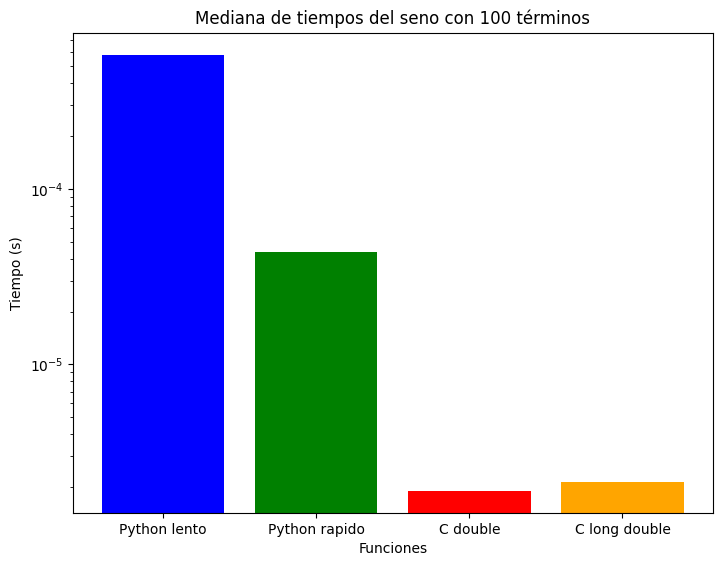

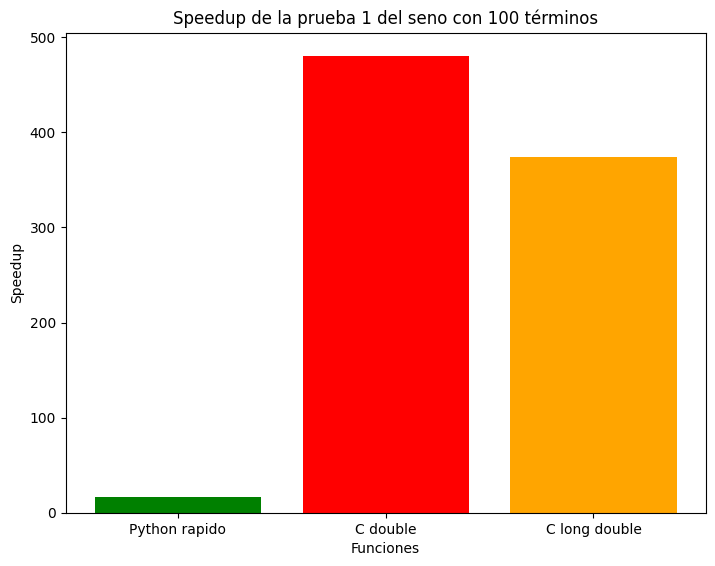

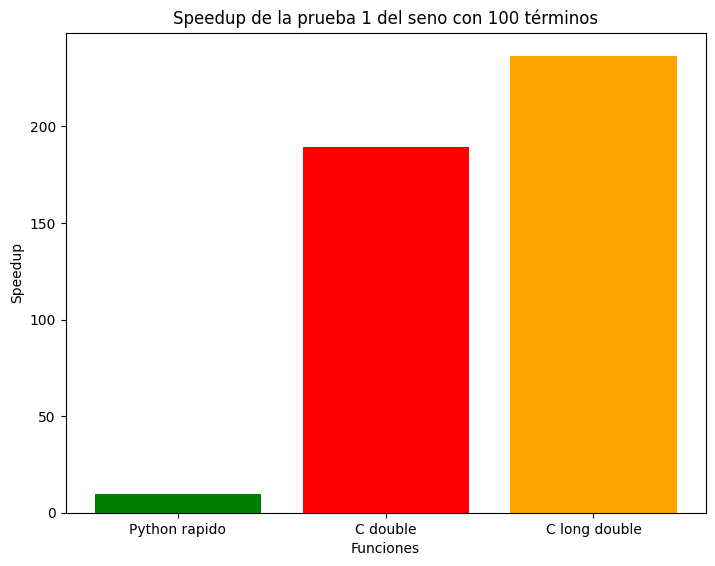

In [39]:
import matplotlib.pyplot as plt

# Definir las funciones y sus nombres
funciones = [py_slow_sin, py_fast_sin, c_sin_double, c_sin_long_double]
nombres = ['Python lento', 'Python rapido', 'C double', 'C long double']

# Calcular medianas de los tiempos
medianas_tiempos = []

for func in funciones:
    mediana = encontrar_mediana_de_mediciones_sin(func, ang_min, n_terms, n_iter)
    medianas_tiempos.append(mediana)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(nombres, medianas_tiempos, color=['blue', 'green', 'red', 'orange'])
plt.title(f'Mediana de tiempos del seno con {n_terms} términos')
plt.xlabel('Funciones')
plt.ylabel('Tiempo (s)')
plt.yscale('log')  # Escala logarítmica en el eje y para una mejor visualización de las diferencias
plt.show()

speedups1 = [
    mediana_py_slow_sin_1 / mediana_py_fast_sin_1,
    mediana_py_slow_sin_1 / mediana_c_sin_double_1,
    mediana_py_slow_sin_1 / mediana_c_sin_long_double_1 ]

# Crear gráfico de barras para los speedups
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
casos = ['Python rapido', 'C double', 'C long double']
ax.bar(casos, speedups1, color=['green', 'red', 'orange'])
plt.title(f'Speedup de la prueba 1 del seno con {n_terms} términos')
plt.xlabel('Funciones')
plt.ylabel('Speedup')
plt.show()

speedups2 = [
    mediana_py_slow_sin_2 / mediana_py_fast_sin_2,
    mediana_py_slow_sin_2 / mediana_c_sin_double_2,
    mediana_py_slow_sin_2 / mediana_c_sin_long_double_2 ]

# Crear gráfico de barras para los speedups
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
casos = ['Python rapido', 'C double', 'C long double']
ax.bar(casos, speedups2, color=['green', 'red', 'orange'])
plt.title(f'Speedup de la prueba 1 del seno con {n_terms} términos')
plt.xlabel('Funciones')
plt.ylabel('Speedup')
plt.show()

12. Implemente una función en `Python` que calcule el seno de los ángulos en el dominio $[inf, sup]$

Nombre de la función: `calc_sins`

Argumentos:
* `f`: función
* `inf`: extremo izquierdo del dominio
* `sup`: extremo derecho del dominio
* `n_angs`: cantidad de ángulos
* `n_terms`: cantidad de términos de la función `f`

Resultado: Arreglo de `numpy` con los senos de los ángulos

Observación: Puede emplear la función `linspace` del módulo `numpy` para crear su arreglo de ángulos.

In [40]:
import numpy as np

def calc_sins(f, inf, sup, n_angs, n_terms):
    angles = np.linspace(inf, sup, n_angs)
    sins = np.array([f(angle, n_terms) for angle in angles])
    return sins

13. Implemente una función que realice una cantidad de mediciones de tiempo de su función anterior y devuelva la mediana de esas mediciones.

Nombre de la función: `encontrar_mediana_de_mediciones_calc_sins`

Argumentos:
* `f`: función
* `inf`: extremo izquierdo del dominio
* `sup`: extremo derecho del dominio
* `n_terms`: cantidad de términos de la función
* `n_iter`: cantidad de iteraciones

Resultado: Mediana de las mediciones realizadas.

Observación: Puede emplear la función `median` del módulo `statistics`.

In [41]:
import time
import statistics

def encontrar_mediana_de_mediciones_calc_sins(f, inf, sup, n_terms, n_iter):
    tiempos2 = []
    for _ in range(n_iter):
        start_time = time.time()
        calc_sins(f, inf, sup, 1000, n_terms)  # Realizar mediciones con 1000 ángulos
        end_time = time.time()
        tiempos2.append(end_time - start_time)

    mediana2 = statistics.median(tiempos2)
    return mediana2

14. Haga pruebas de `encontrar_mediana_de_mediciones_sins` para cada una de sus funciones. 

Observaciones:

* Los valores para `inf`, `sup`, `n_angs` y `n_iter` serán los mismos que los definidos anteriormente
* Cada función empleará su cantidad de términos previamente calculados
* Cada resultado deberá ser asignado a una variable independiente

In [42]:
inf = -2 * np.pi
sup = 2 * np.pi
n_angs = 1000
n_iter = 50 

mediana_py_slow_calc_sins = encontrar_mediana_de_mediciones_calc_sins(py_slow_sin, inf, sup, n_terms_slow, n_iter)
mediana_py_fast_calc_sins = encontrar_mediana_de_mediciones_calc_sins(py_fast_sin, inf, sup, n_terms_fast, n_iter)
mediana_c_double_calc_sins = encontrar_mediana_de_mediciones_calc_sins(c_sin_double, inf, sup, n_terms_c_double, n_iter)
mediana_c_long_double_calc_sins = encontrar_mediana_de_mediciones_calc_sins(c_sin_long_double, inf, sup, n_terms_c_longdouble, n_iter)

mediana_py_slow_calc_sins, mediana_py_fast_calc_sins, mediana_c_double_calc_sins, mediana_c_long_double_calc_sins

(0.8860164880752563,
 0.1079627275466919,
 0.002931356430053711,
 0.0032966136932373047)

15. Presente gráficas de barras de las medianas calculadas en el item anterior y de los speedups a partir de los resultados del ítem anterior.

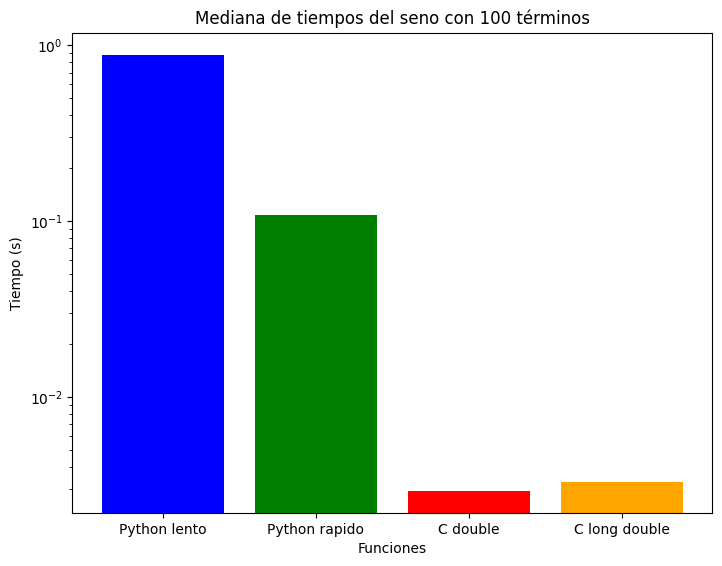

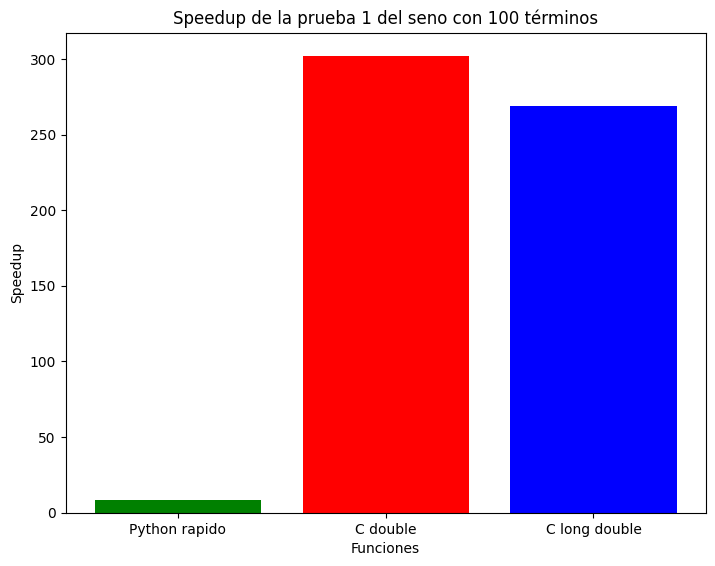

In [44]:
import matplotlib.pyplot as plt

# Definir las funciones y sus nombres
funciones = [py_slow_sin, py_fast_sin, c_sin_double, c_sin_long_double]
nombres = ['Python lento', 'Python rapido', 'C double', 'C long double']

# Calcular medianas de los tiempos
medianas_tiempos2 = [mediana_py_slow_calc_sins, mediana_py_fast_calc_sins, mediana_c_double_calc_sins, mediana_c_long_double_calc_sins]

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(nombres, medianas_tiempos2, color=['blue', 'green', 'red', 'orange'])
plt.title(f'Mediana de tiempos del seno con {n_terms} términos')
plt.xlabel('Funciones')
plt.ylabel('Tiempo (s)')
plt.yscale('log')  # Escala logarítmica en el eje y para una mejor visualización de las diferencias
plt.show()

speedups3 = [
    mediana_py_slow_calc_sins / mediana_py_fast_calc_sins,
    mediana_py_slow_calc_sins / mediana_c_double_calc_sins,
    mediana_py_slow_calc_sins / mediana_c_long_double_calc_sins ]

# Crear gráfico de barras para los speedups
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
casos = ['Python rapido', 'C double', 'C long double']
ax.bar(casos, speedups3, color=['green', 'red', 'blue'])
plt.title(f'Speedup de la prueba 1 del seno con {n_terms} términos')
plt.xlabel('Funciones')
plt.ylabel('Speedup')
plt.show()



## Distribución de puntaje

| ítem | puntos |
|:----:|:------:|
|   1  |    1   |
|   2  |    2   |
|   3  |    4   |
|   4  |   0.5  |
|   5  |   0.5  |
|   6  |   0.5  |
|   7  |   1.5  |
|   8  |   0.5  |
|   9  |   1.5  |
|  10  |   0.5  |
|  11  |   0.5  |
|  12  |   0.5  |
|  13  |   0.5  |
|  14  |   0.5  |
|  15  |   0.5  |